In [2]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd

In [3]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [4]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [5]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [6]:
def get_SFH(snapnum, subID, tbins, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - sub['SubhaloPos']
    r = np.linalg.norm(pos, axis=1)
    rhalf = sub['SubhaloHalfmassRadType'][4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.1
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN


In [32]:
def make_plot(subID, snapnum, output_dir=None, save=False, slope=0,
              logFeH0_list=[-0.75, -0.5, -0.25, 0]):
    t_snapnum = meta['time'][snapnum]
    tbins = np.linspace(0, t_snapnum, 100)
    tlim = [tbins[0], tbins[-1]]
    
    tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, logFeH0_list)

    # given as a positive number, so make negative
    slope *= -1
    t_snapnum = meta['time'][snapnum]
    logMgFe_slope = logMgFe + slope * (tform - t_snapnum)
    
    # fig, axs = plt.subplots(3, 1, figsize=(3, 8))

    # axs[0].axhline(1, c='k', alpha=0.25)
    # axs[0].axhline(2, c='k', alpha=0.25)

    # axs[0].plot(tcenter, sfh[:,0], c='k')
    # axs[0].set(xlim=(0, t_snapnum))
    # axs[0].set(ylim=(0, 25))
    # axs[0].set_yticks(np.arange(0, 25+1, 1), minor=True)
    # axs[0].set_title(str(subID))
    
    # for i in range(1, sfh.shape[1]):
        # axs[1].plot(tcenter, sfh[:,i])

    # axs[1].set(xlim=(0, t_snapnum), ylim=(0, 25))
    
    # offset = 0
    # doffset = -0.25
    # for key in keys:
        # axs[2].scatter(tform[key], logMgFe[key]+offset, s=0.5, alpha=0.1)
        # offset += doffset
    
    # axs[2].set(xlim=(0, t_snapnum), ylim=(-0.75, 0.75))
    
    # fig.savefig(output_dir + '/'+str(subID)+'_sfh.png')
    
    # plt.close()
    
    fig, axs = plt.subplots(2, 2, figsize=(textwidth, 1.5*columnwidth))
    logFeH_lim = (-1.5, 0.5)
    logMgFe_lim = (0, 1.0)
    N_FeH = 125
    N_MgFe = 125
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    H0, _, _, _ = binned_statistic_2d(logFeH[is_star_in_SN], logMgFe[is_star_in_SN], 
                                     np.ones(np.sum(is_star_in_SN))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    H1, _, _, _ = binned_statistic_2d(logFeH[is_star_in_SN], logMgFe_slope[is_star_in_SN], 
                                     np.ones(np.sum(is_star_in_SN))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im0 = axs[0][0].imshow(H0.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                      logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', norm=mpl.colors.LogNorm())
    
    im1 = axs[0][1].imshow(H1.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                      logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', norm=mpl.colors.LogNorm())
    
    axs[0][0].set(xlim=logFeH_lim, ylim=logMgFe_lim)
    axs[0][0].set_aspect('auto')
    
    axs[0][1].set(xlim=logFeH_lim, ylim=logMgFe_lim)
    axs[0][1].set_aspect('auto')
    
    
    # ------- MgFe vs time ------- #
    cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
    offset = 0
    doffset = -0.3
    # ybins = [MgFe_bins[0]+doffset*3, MgFe_bins[1]]
    ybins = np.arange(logMgFe_lim[0]+doffset*3, logMgFe_lim[1] + dMgFe, dMgFe)
    
    print(ybins)
    for cmap, key in zip(cmaps, keys):
        H0, _, _, _ = binned_statistic_2d(tform[is_star_in_SN], logMgFe[is_star_in_SN]+offset, 
                                     np.ones(np.sum(is_star_in_SN))/dFeH/dMgFe,
                                     statistic='sum', bins=[tbins, ybins])
    
        H1, _, _, _ = binned_statistic_2d(tform[is_star_in_SN], logMgFe_slope[is_star_in_SN]+offset, 
                                     np.ones(np.sum(is_star_in_SN))/dFeH/dMgFe,
                                     statistic='sum', bins=[tbins, ybins])
    
        im0 = axs[1][0].imshow(H0.T, origin='lower', extent=[tlim[0],  tlim[1],
                                                      logMgFe_lim[0], logMgFe_lim[1]],
                       cmap=cmap, norm=mpl.colors.LogNorm(), alpha=0.5)
    
        im1 = axs[1][1].imshow(H1.T, origin='lower', extent=[tlim[0],  tlim[1],
                                                      logMgFe_lim[0], logMgFe_lim[1]],
                       cmap=cmap, norm=mpl.colors.LogNorm(), alpha=0.5)
        
        offset += doffset
    
    axs[1][0].set(xlim=tlim, ylim=[logMgFe_lim[0]+3*doffset, logMgFe_lim[1]])
    axs[1][0].set_aspect('auto')
    
    axs[1][1].set(xlim=tlim, ylim=[logMgFe_lim[0]+3*doffset, logMgFe_lim[1]])
    axs[1][1].set_aspect('auto')
    
    # dlogFeH0 = 0.05
    # d = 0.25/2
    # offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
    # for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
    # for i,logFeH0 in enumerate(logFeH0_list):
        # offset = offset_list[i]
        # key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
        # key = np.logical_and(key, is_star_in_SN)
    
        # bins = np.linspace(-d, 1+d, 200+1)
        # binsplot = 0.5*(bins[1:] + bins[:-1])
        # hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key])+offset, 
                               # bins=bins, density=True)
        # l = axs[1].plot(binsplot, hist, lw=1)
    
        # axs[0].axvline(logFeH0, c=l[0].get_color())
        
        # offset += doffset
    
    # axs[1].set(ylim=(0, 20), xlim=(bins[0], bins[-1]))
    # axs[0].set_title(str(subID))
    
    # fig.savefig(output_dir + '/'+str(subID)+'_plane.png')
    
    # plt.close()

/tmp/ipykernel_557135/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))


[-0.9   -0.892 -0.884 -0.876 -0.868 -0.86  -0.852 -0.844 -0.836 -0.828
 -0.82  -0.812 -0.804 -0.796 -0.788 -0.78  -0.772 -0.764 -0.756 -0.748
 -0.74  -0.732 -0.724 -0.716 -0.708 -0.7   -0.692 -0.684 -0.676 -0.668
 -0.66  -0.652 -0.644 -0.636 -0.628 -0.62  -0.612 -0.604 -0.596 -0.588
 -0.58  -0.572 -0.564 -0.556 -0.548 -0.54  -0.532 -0.524 -0.516 -0.508
 -0.5   -0.492 -0.484 -0.476 -0.468 -0.46  -0.452 -0.444 -0.436 -0.428
 -0.42  -0.412 -0.404 -0.396 -0.388 -0.38  -0.372 -0.364 -0.356 -0.348
 -0.34  -0.332 -0.324 -0.316 -0.308 -0.3   -0.292 -0.284 -0.276 -0.268
 -0.26  -0.252 -0.244 -0.236 -0.228 -0.22  -0.212 -0.204 -0.196 -0.188
 -0.18  -0.172 -0.164 -0.156 -0.148 -0.14  -0.132 -0.124 -0.116 -0.108
 -0.1   -0.092 -0.084 -0.076 -0.068 -0.06  -0.052 -0.044 -0.036 -0.028
 -0.02  -0.012 -0.004  0.004  0.012  0.02   0.028  0.036  0.044  0.052
  0.06   0.068  0.076  0.084  0.092  0.1    0.108  0.116  0.124  0.132
  0.14   0.148  0.156  0.164  0.172  0.18   0.188  0.196  0.204  0.212
  0.22

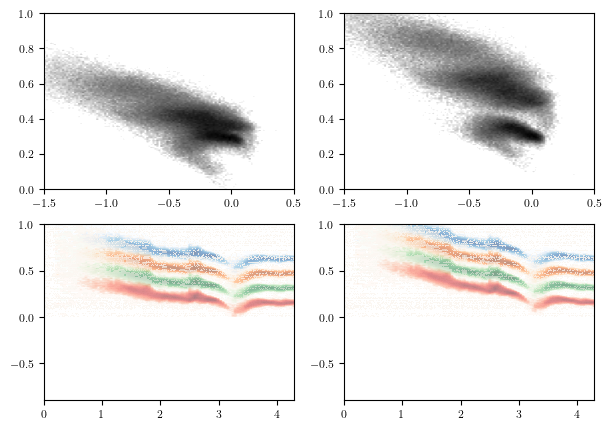

In [33]:
make_plot(172175, 40, slope=0.1)